In [1]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
import numpy as np
import pandas as pd
import pickle
from fair_loss import FairLoss
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import BinaryFairness
from fairlearn.metrics import demographic_parity_ratio,  demographic_parity_difference
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, balanced_accuracy_score,recall_score, confusion_matrix

# from datasets import ADULT, German, Lawschool, HealthHeritage
# from defenses import dp_defense

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available.


In [3]:
class LinReLU(nn.Module):

    """
    A linear layer followed by a ReLU activation layer.
    """    
    
    def __init__(self, in_size, out_size):
        super(LinReLU, self).__init__()      
        linear = nn.Linear(in_size, out_size)
        ReLU = nn.ReLU()
        # self.Dropout = nn.Dropout(0.25)
        self.layers = nn.Sequential(linear, ReLU)

    def reset_parameters(self):
        self.layers[0].reset_parameters()
        return self

    def forward(self, x):
        x = self.layers(x)
        return x

class FullyConnected(nn.Module):
    """
    A simple fully connected neural network with ReLU activations.
    """
    def __init__(self, input_size, layout):

        super(FullyConnected, self).__init__()
        layers = [nn.Flatten()]  # does not play any role, but makes the code neater
        prev_fc_size = input_size
        for i, fc_size in enumerate(layout):
            if i + 1 < len(layout):
                layers += [LinReLU(prev_fc_size, fc_size)]
            else:
                layers += [nn.Linear(prev_fc_size, 1), nn.Sigmoid()]
                # layers += [nn.Linear(prev_fc_size, fc_size)]
            prev_fc_size = fc_size
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x

In [16]:

layout = [100, 100, 2]
batch_size = 32
num_epochs = 5  
input_dim = 10

model = FullyConnected(input_dim, layout)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01) 


model_name="CA"
# [ "CA-","FL","GA","IL-","OH","PA","TX"]
# model.load_state_dict(torch.load(f'50_clients_data/clients_trained_model/{model_name}.pth'))
# model.load_state_dict(torch.load(f'50_clients_data/client_DP_trained_model/{model_name}.pth'))
# model.load_state_dict(torch.load(f'50_clients_data/clients_fair_trained_model/{model_name}.pth'))
model.load_state_dict(torch.load(f'50_clients_data/clients_DP_Fair_trained_model/{model_name}.pth'))

<All keys matched successfully>

# Testing on SubGroup
1. BM
2. BW
3. WM
4. WW

- I am using .pkl for testing (WW_test.. and other files have less data)

In [17]:
client_data_dir='50_clients_data/client_subG_processed/'

state_codes=["WW","WM","BM","BW"]
for state_code in state_codes:
    print(state_code)

    with open(client_data_dir + f'{state_code}.pkl', 'rb') as f:
        test_data = pickle.load(f)

    total_length = sum(len(batch[0]) for batch in test_data)
    print(f'Total length of {state_code} test data: {total_length}')

WW
Total length of WW test data: 4437
WM
Total length of WM test data: 4673
BM
Total length of BM test data: 680
BW
Total length of BW test data: 784


In [18]:
four_client_result_ori=[]
four_client_result_pred=[]
four_client_result_TPR={}
four_client_result_cm={}


for state_code in state_codes:

    with open(client_data_dir + f'{state_code}.pkl', 'rb') as f:
        test_data = pickle.load(f)

    # total_length = sum(len(batch[0]) for batch in test_data)
    # print(f'Total length of {state_code} test data: {total_length}')
    
    temp_out = []
    temp_lab = []
    temp_group = []
    all_actaul_y=[]
    all_pred_y=[]
    temp_list_act=[]
    temp_list_pred=[]
    all_labels = []
    all_predicted_classes = []
    size_of_data=[]
    raw_out=[]

    model.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0        

        for i, (inputs, labels) in enumerate(test_data):
            # if i >= 50: #50*32 =1600 points:
            #     print(i)
            #     break
            
            labels = labels.unsqueeze(1).float()
            temp_lab.append(labels)
            outputs = model(inputs)
            
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

            raw_out.append(outputs)
            
            predicted_classes = (outputs > 0.6).float()
            
            temp_out.append(predicted_classes)

            val_correct += (predicted_classes == labels).sum().item()
            val_total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predicted_classes.extend(predicted_classes.cpu().numpy())

        val_epoch_loss = val_running_loss / len(test_data)
        val_accuracy = val_correct / val_total

        tpr = recall_score(all_labels, all_predicted_classes)
        f1 = f1_score(all_labels, all_predicted_classes)
        cm = confusion_matrix(all_labels, all_predicted_classes)

        all_labels = np.array(all_labels)
        print(f"Total length of {state_code} :", len(all_labels))
        all_predicted_classes = np.array(all_predicted_classes)

        four_client_result_ori.append(all_labels)
        four_client_result_pred.append(all_predicted_classes)
        four_client_result_TPR[state_code] = tpr
        four_client_result_cm[state_code] = cm
        
        print("val_epoch_loss:",val_epoch_loss, "  val_accuracy:", val_accuracy, "  TPR:", tpr)

print(cm)


Total length of WW : 4437
val_epoch_loss: 0.5846322599074824   val_accuracy: 0.6970926301555105   TPR: 0.6547052361772244
Total length of WM : 4673
val_epoch_loss: 0.6295122526535372   val_accuracy: 0.7348598330836722   TPR: 0.7657657657657657
Total length of BM : 680
val_epoch_loss: 0.5623600022359327   val_accuracy: 0.7279411764705882   TPR: 0.6995708154506438
Total length of BW : 784
val_epoch_loss: 0.5575929260253907   val_accuracy: 0.7155612244897959   TPR: 0.6752293577981652
[[193  46]
 [177 368]]


In [19]:
# temp_lab[0],raw_out[0],temp_out[0]

In [20]:
four_client_result_cm

# [[TP, FP],  
#  [FN, TN]]

{'WW': array([[1305,  401],
        [ 943, 1788]]),
 'WM': array([[1734,  719],
        [ 520, 1700]]),
 'BM': array([[169,  45],
        [140, 326]]),
 'BW': array([[193,  46],
        [177, 368]])}

In [21]:
four_client_result_TPR

{'WW': np.float64(0.6547052361772244),
 'WM': np.float64(0.7657657657657657),
 'BM': np.float64(0.6995708154506438),
 'BW': np.float64(0.6752293577981652)}

In [22]:
WW_pred=four_client_result_pred[0].flatten().tolist()
WM_pred=four_client_result_pred[1].flatten().tolist()
BM_pred=four_client_result_pred[2].flatten().tolist()
BW_pred=four_client_result_pred[3].flatten().tolist()

WW_ori=four_client_result_ori[0].flatten().tolist()
WM_ori=four_client_result_ori[1].flatten().tolist()
BM_ori=four_client_result_ori[2].flatten().tolist()
BW_ori=four_client_result_ori[3].flatten().tolist()

In [23]:
def get_prob(y_pred, y_ori):
    matches_0 = 0
    matches_1 = 0
    total_zeros = 0
    total_ones = 0
    
    for pred, ori in zip(y_pred, y_ori):
        if ori == 0:  # Count for label 0
            total_zeros += 1
            if pred == ori:
                matches_0 += 1
        elif ori == 1:  # Count for label 1
            total_ones += 1
            if pred == ori:
                matches_1 += 1
    
    # Avoid division by zero
    prob_0 = matches_0 / total_zeros if total_zeros != 0 else 0
    prob_1 = matches_1 / total_ones if total_ones != 0 else 0
    
    return [prob_0, prob_1]


In [24]:
all_subG_pred=[WW_pred,WM_pred,BM_pred,BW_pred]
all_subG_ori=[WW_ori,WM_ori,BM_ori,BW_ori]
prob_all_sub=[]
sub_dict={"WW":0,"WM":0,"BM":0,"BW":0}
for idx, sgrp in enumerate(sub_dict.keys()):
    prob = get_prob(all_subG_pred[idx], all_subG_ori[idx])
    sub_dict[sgrp] = prob


sub_dict

{'WW': [0.764947245017585, 0.6547052361772244],
 'WM': [0.7068895230330208, 0.7657657657657657],
 'BM': [0.7897196261682243, 0.6995708154506438],
 'BW': [0.8075313807531381, 0.6752293577981652]}

In [25]:
def divide_dict_values(sub_dict):
    results = {}
    for key1, value1 in sub_dict.items():
        for key2, value2 in sub_dict.items():
            if key1 != key2:
                try:
                    result = [v1 / v2 if v2 != 0 else float('nan') for v1, v2 in zip(value1, value2)]
                    results[f'{key1}/{key2}'] = result
                    print(f'{key1}/{key2} = {result}')
                except ZeroDivisionError:
                    print(f'{key1}/{key2} = Division by zero error')
        print("====================")
    return results

In [26]:


def plot_results(model_name,results):
    ratios = list(results.keys())
    label0_values = [result[0] for result in results.values()]
    label1_values = [result[1] for result in results.values()]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    x = np.arange(len(ratios))
    
    # Plot for Label 0
    ax1.bar(x, label0_values, width=0.6, color='skyblue', alpha=0.8)
    ax1.set_ylabel('Values')
    ax1.set_title('Label 0')
    ax1.set_xticks(x)
    ax1.set_xticklabels(ratios, rotation=45, ha='right')
    ax1.axhline(y=1, color='r', linestyle='--', alpha=0.5)

    # Plot for Label 1
    ax2.bar(x, label1_values, width=0.6, color='lightgreen', alpha=0.8)
    ax2.set_ylabel('Values')
    ax2.set_title('Label 1')
    ax2.set_xticks(x)
    ax2.set_xticklabels(ratios, rotation=45, ha='right')
    ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"graphs/{model_name}.png", dpi=300, bbox_inches='tight')
    plt.show()


WW/WM = [1.0821312526113818, 0.8549680143020225]
WW/BM = [0.9686314226849893, 0.935866994044744]
WW/BW = [0.9472662775088229, 0.9696042220559438]
WM/WW = [0.9241023189994891, 1.1696343995001712]
WM/BM = [0.895114543958973, 1.0946222295915546]
WM/BW = [0.8753709637559168, 1.1340824520172346]
BM/WW = [1.0323844308375407, 1.0685279065971522]
BM/WM = [1.1171754573187165, 0.9135571825296643]
BM/BW = [0.977942956757542, 1.036049169621198]
BW/WW = [1.0556693759117652, 1.031348644377399]
BW/WM = [1.1423728240988742, 0.8817701025364275]
BW/BM = [1.0225545294743879, 0.965205155625598]


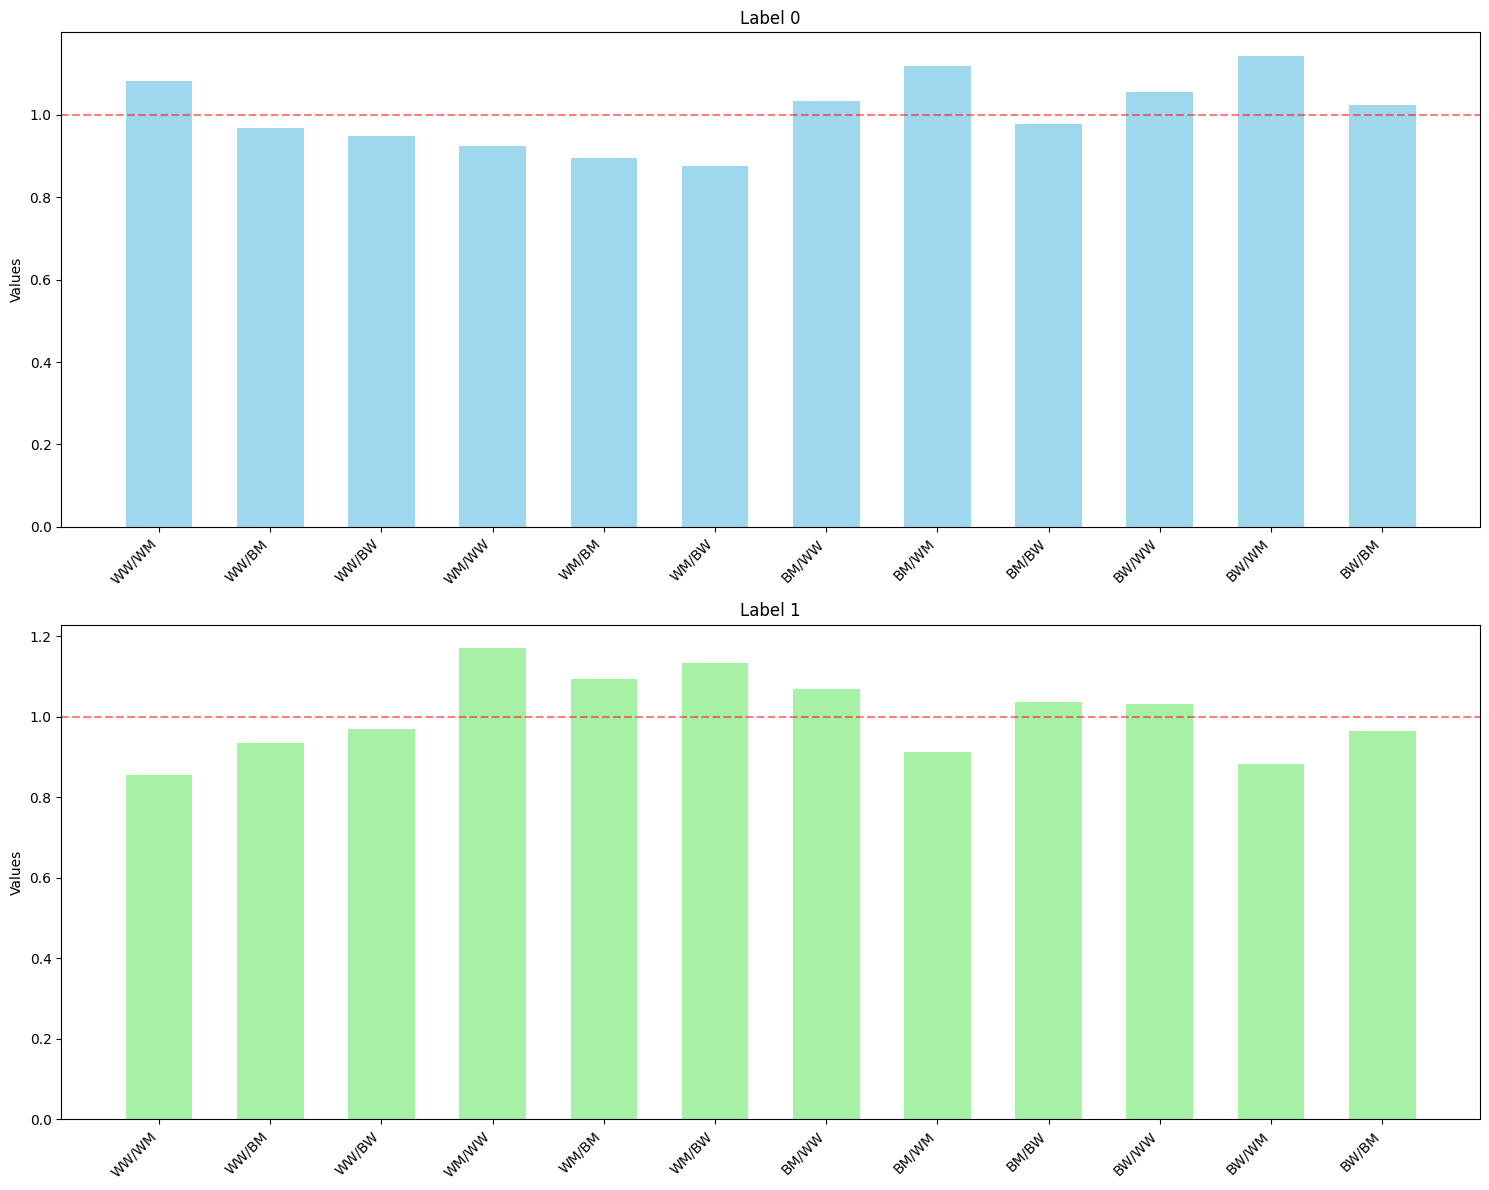

In [27]:
result_a=divide_dict_values(sub_dict)

plot_results(model_name,result_a)

In [17]:
# def divide_dict_values(sub_dict):
#     # Iterate over each key-value pair in the dictionary
#     for key1, value1 in sub_dict.items():
#         for key2, value2 in sub_dict.items():
#             if key1 != key2:  # Ensure we don't divide a value by itself
#                 try:
#                     # Perform element-wise division for the lists
#                     result = [v1 / v2 if v2 != 0 else 'Division by zero error' for v1, v2 in zip(value1, value2)]
#                     print(f'{key1}/{key2} = {result}')
#                 except ZeroDivisionError:
#                     print(f'{key1}/{key2} = Division by zero error')
#         print("====================")
# print("Left side label:0 , Right side label:1 \n")
# divide_dict_values(sub_dict)
